In [1]:
import pandas as pd
import os
import torch
from PIL import Image
from transformers import CLIPModel
from transformers import CLIPProcessor
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import cv2
import webcolors
import faiss
from torchvision import models, transforms
import time

In [2]:
def display_images_and_titles(filepaths, titles):
    # Create a 3x5 grid of subplots
    fig, axes = plt.subplots(3, 5, figsize=(12, 10))

    # Loop through the filepaths and display images in the subplots
    for i, ax in enumerate(axes.flatten()):
        if i < len(filepaths):
            filepath = filepaths[i]
            image = plt.imread(filepath)
            ax.imshow(image)
            ax.axis('off')

            # Assign a title to each subplot
            ax.set_title(f"{titles[i]}", fontsize = 7)
        else:
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def display_images_titles_from_ids(ids, directory, df):
    df_new_index = df.copy()
    df_new_index['id'] = df_new_index['id'].astype(str)
    df_new_index.set_index("id",inplace = True)
    df_new_index = df_new_index.loc[ids]
    filenames = df_new_index.index.tolist()
    filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
    titles =  df_new_index.productDisplayName.tolist()
    
    display_images_and_titles(filepaths, titles)

    


In [3]:
def clip_search_image_and_text_overall_distance(path_to_image, text):
    #Import dataset
    filename = "./myntradataset/styles.csv" # Modify directory
    df = pd.read_csv(filename, on_bad_lines="skip") #some lines of the dataset fail due to excess commas
    
    #Data Wrangling
    available_ids = os.listdir("./myntradataset/images") # Modify directory
    available_ids = [int(x.replace(".jpg","")) for x in available_ids]
    df = df[df.id.isin(available_ids)] #some images are not actually available
    df=df.dropna(subset='productDisplayName')

    custom_image = Image.open(path_to_image)

    # Load model
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") #Import CLIP Model
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    #Extract text and image embeddings 
    image_vectors = torch.load("image_tensor.pt") # Modify directory
    image_vectors_np = image_vectors.numpy()

    text_vectors = torch.load("title_tensor.pt") # Modify directory
    text_vectors_np = text_vectors.numpy()

    knn_labels = df.id.astype(str).tolist()

    # Build the index
    dimension = image_vectors_np.shape[1]  # Dimension of the vectors
    index_image = faiss.IndexFlatL2(dimension)
    index_image.add(image_vectors_np)

    # Preprocess the custom image and text 
    inputs = processor(text=text, images=custom_image, return_tensors="pt", padding=True)

    # Perform inference on the custom image and text
    outputs = model(**inputs)
    
    #knn for text 
    np_text_emb = outputs.text_embeds.detach().cpu().numpy() #Get text query embedding
    k= df.shape[0] # Number of text neighbors to return
    D_text, I_text = index_image.search(np_text_emb.reshape(1, -1) , k)
    D_text[0] = D_text[0][np.argsort(I_text[0])]
    
    #knn for image
    np_image_emb = outputs.image_embeds.detach().cpu().numpy() #Get image query embedding
    #k_image= 450 # Number of image neighbors to return
    D_image, I_image = index_image.search(np_image_emb.reshape(1, -1), k)
    D_image[0] = D_image[0][np.argsort(I_image[0])]

    #for just color
    #D_overall = 1.3*D_text[0]+D_image[0]

    #for patterns
    D_overall = D_text[0]+D_image[0]

    
    indices = np.argsort(D_overall).tolist()

    top_indices = indices[0:15]

    # Retrieve the corresponding labels 
    top_ids = [knn_labels[i] for i in top_indices]
    
    return top_ids, df  

In [4]:
#Setting up SAM

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [5]:
#Setting up SAM

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

#whereever you loaded your vit_h file, will need to modify
sam_checkpoint ="/Users/meagankenney/IMA Bootcamp/Ebay/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
#sam.to(device=device)

predictor = SamPredictor(sam)

In [6]:
#A function to scale a list into a specified rante
def scale_list(values, min_val, max_val):
    # Convert the list to a NumPy array
    arr = np.array(values)

    # Find the minimum and maximum values in the array
    arr_min = np.min(arr)
    arr_max = np.max(arr)

    # Scale the values to be between min_val and max_val
    scaled_arr = (arr - arr_min) * (max_val - min_val) / (arr_max - arr_min) + min_val

    # Convert the scaled array back to a list
    scaled_list = scaled_arr.tolist()

    return scaled_list

In [7]:
#This allows you to click a point on the image to indicate an input for SAM
import cv2

def get_clicked_point(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Create a copy of the image for display
    display_image = image.copy()

    # Flag to indicate if a point has been captured
    point_captured = False

    # Variables to store the clicked coordinates
    clicked_x = None
    clicked_y = None

    def click_callback(event, x, y, flags, param):
        nonlocal point_captured, clicked_x, clicked_y

        # Check if the left mouse button is pressed
        if event == cv2.EVENT_LBUTTONDOWN and not point_captured:
            # Store the clicked coordinates
            clicked_x = x
            clicked_y = y

            # Print the coordinates
            #print(f"Clicked coordinates: x={clicked_x}, y={clicked_y}")

            # Draw a circle at the clicked point
            cv2.circle(display_image, (clicked_x, clicked_y), 5, (0, 0, 255), -1)
            cv2.imshow("Image", display_image)

            # Set the flag to indicate a point has been captured
            point_captured = True

    # Create a window and set the callback function
    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", click_callback)

    # Display the image
    cv2.imshow("Image", display_image)

    # Wait for a point to be captured or 'Esc' key is pressed
    while not point_captured:
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # 'Esc' key
            break

    # Close all windows
    cv2.destroyAllWindows()

    # Return the clicked coordinates if a point was captured, otherwise return None
    if point_captured:
        return [(clicked_x, clicked_y)]
    else:
        return None
    
    


In [8]:
#look here for color and pattern changes
def doColorAndPatternChange(color, pattern, image_path, name):
    #TWhile I have the selection of a point here, incorporating the rectangle and point input for SAM could improve this
    print("Make sure to click a point on the pop up image for this function to continue on.")
    clicked_point = get_clicked_point(image_path)

    
    #Store image properly for code below
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image1 = image.copy()
    #sets SAM based on that image
    predictor.set_image(image)
    
    #These inputs might be altered again if the rectangle for SAM is implemented
    input_point = np.array(clicked_point)
    input_label = np.array([1])
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    
    #Store which points of are pixel fall in the selected max
    int_mask = masks.astype(int)
    
    
    width = image.shape[0]
    height = image.shape[1]
    
    #Puts white background on image 
    for i in range(width):
        for j in range(height):
            # getting the current RGB value of pixel (i,j).
            if int_mask[0][i][j]==0:
                  image[i][j]=(255,255,255)
    
    #Finds the average color of the pixels on the mask
    colList=[]
    for i in range(width):
        for j in range(height):
            # getting the current RGB value of pixel (i,j).
            if int_mask[0][i][j]==1:
                colList.append(image[i][j])
    L=len(colList)
    m1=0
    m2=0
    m3=0
    for i in colList:
        m1+=i[0]
        m2+=i[1]
        m3+=i[2]
    AvgCol = [(m1/L, m2/L, m3/L)]
    
    
    #This is where the pattern change part starts
    if pattern != "keep original":
        pattern_name = root.selection.replace(" ", "_")
        #will need to modify next location where image is saved
        pattern_path = '/Users/meagankenney/IMA Bootcamp/Ebay/VisualSearch/Fabric_Swatches/' + pattern_name + ".jpeg"
        pattern = Image.open(pattern_path)
        
        #Resize selected fabric swatch to the size of the image being altered
        pattern_resized = pattern.resize((height, width))
        pattern_resized.save(pattern_path)

        pattern = cv2.imread(pattern_path)
        pattern = cv2.cvtColor(pattern, cv2.COLOR_BGR2RGB)



        #Fix a base color
        startCol = AvgCol

        dif = []


        #Store how different is this base color from target color on the pixels we're changing in order to retain details of the clothing item
        for i in range(width):
            for j in range(height):
                if int_mask[0][i][j]==1:
                    dif1 = startCol[0][0] - pattern[i][j][0]
                    dif2 = startCol[0][1] - pattern[i][j][1]
                    dif3 = startCol[0][2] - pattern[i][j][2]
                    #dif1 = pattern[i][j][0]
                    #dif2 =  pattern[i][j][1]
                    #dif3 =  pattern[i][j][2]
                    dif.append((dif1,dif2,dif3))

        #Make blank list for new color values
        newColR=[]
        newColG=[]
        newColB=[]

        #Make lists of the shifted colors from old to new RGB values
        c= 0
        for i in range(width):
            for j in range(height):
                if int_mask[0][i][j]==1:
                    newColR.append(image[i][j][0]-dif[c][0])
                    newColG.append(image[i][j][1]-dif[c][1])
                    newColB.append(image[i][j][2]-dif[c][2])
                    c+=1

        #Rescale each color list to make sure it's in appropriate RGB value range
        minR = max(min(newColR), 0)
        maxR = min(max(newColR), 255)
        minG = max(min(newColG), 0)
        maxG = min(max(newColG), 255)
        minB = max(min(newColB), 0)
        maxB = min(max(newColB), 255)
        fixedColR = scale_list(newColR, minR,maxR)
        fixedColG = scale_list(newColG, minG,maxG)
        fixedColB =scale_list(newColB, minB,maxB)


        #Go through all pixels in the picture and set them to their new color
        n=0
        for i in range(width):
            for j in range(height):
                # Is this picture on the segment we're recoloring?
                if int_mask[0][i][j]==1:
                    image[i][j][0]=fixedColR[n]
                    image[i][j][1]=fixedColG[n]
                    image[i][j][2] = fixedColB[n]
                    n+=1
                    
        #This does the same on the non-segmented image in case you want to use image1, which retains more than the segmented part from the original image, as your image query            
        n=0
        for i in range(width):
            for j in range(height):
                # Is this picture on the segment we're recoloring?
                if int_mask[0][i][j]==1:
                    image1[i][j][0]=fixedColR[n]
                    image1[i][j][1]=fixedColG[n]
                    image1[i][j][2] = fixedColB[n]
                    n+=1
    
    #here's where the color changing part starts
    if color != "":
        
        #Fix a base color
        startCol = AvgCol
        #Web Colors has a really weird brown 
        if color =="brown":
            color = "saddlebrown"
        color_name = color
        color_name =  color_name.replace(" ", "")
        newColor = get_rgb_from_color_name(color_name)
        
        
        #Note the code above this is replaced by a hex color picker in the Streamlit app which eliinages the need for the code above
        
        #Reduces the intensity of the most pigmented colors like red, blue, and green (Again this is not necessary with the Hex color picker)
        fixColor = []
        fixColor.append(str(newColor[0]))
        fixColor.append(str(newColor[1]))
        fixColor.append(str(newColor[2]))
            
            
        if newColor[0]==255 and newColor[1]==0 and newColor[2]==0:
            fixColor[1] ="65"
            
        if newColor[0]==0 and newColor[1]==255 and newColor[2]==0:
            fixColor[0] = "65"
        if newColor[0]==0 and newColor[1]==0 and newColor[2]==255:
            fixColor[1] = "65"
            
        newColor = (int(fixColor[0]),int(fixColor[1]),int(fixColor[2]))
            
        #Stores how different is this base color from target color (again to retain details of original item)
        dif1 = startCol[0][0] - newColor[0]
        dif2 = startCol[0][1] - newColor[1]
        dif3 = startCol[0][2] - newColor[2]

        #Make blank list for new color values
        newColR=[]
        newColG=[]
        newColB=[]

        #Make lists of the shifted colors from old to new RGB values
        for i in range(width):
            for j in range(height):
                if int_mask[0][i][j]==1:
                    newColR.append(image[i][j][0]-dif1)
                    newColG.append(image[i][j][1]-dif2)
                    newColB.append(image[i][j][2]-dif3)

        #Rescale each color list to make sure it's in appropriate RGB value range
        minR = max(min(newColR), 0)
        maxR = min(max(newColR), 255)
        minG = max(min(newColG), 0)
        maxG = min(max(newColG), 255)
        minB = max(min(newColB), 0)
        maxB = min(max(newColB), 255)
        fixedColR = scale_list(newColR, minR,maxR)
        fixedColG = scale_list(newColG, minG,maxG)
        fixedColB =scale_list(newColB, minB,maxB)


        #Go through all pixels in the picture and set them to their new color
        n=0
        for i in range(width):
            for j in range(height):
                # Is this picture on the segment we're recoloring?
                if int_mask[0][i][j]==1:
                    image[i][j][0]=fixedColR[n]
                    image[i][j][1]=fixedColG[n]
                    image[i][j][2] = fixedColB[n]
                    n+=1
                    
        #This does the same on the non-segmented image in case you want to use image1, which retains more than the segmented part from the original image, as your image query                
        n=0
        for i in range(width):
            for j in range(height):
                # Is this picture on the segment we're recoloring?
                if int_mask[0][i][j]==1:
                    image1[i][j][0]=fixedColR[n]
                    image1[i][j][1]=fixedColG[n]
                    image1[i][j][2] = fixedColB[n]
                    n+=1
    
    #Shows the original image with the alterations
    plt.imshow(image1)
    #Shows the original image with the alterations
    #plt.imshow(image1
    
    #Saves the altered image so it can be put into the normal search
    #will need to modify where image is saved
    #Change "image" to "image1" in the lien below if you'd like to keep the unsegmented parts of the image for your image query
    img = Image.fromarray(image, "RGB")
    local_pic = img.save("patternChanged.jpeg")
    local_pic =  '/Users/meagankenney/IMA Bootcamp/Ebay/VisualSearch/patternChanged.jpeg'
    
    
    #Now this is the normal search of the directory with image and text 
    #embeddings with Chiara's second ordering using the weights in cell 3 line 54
    #Will need to modify where to access the directory
    top_ids, df =clip_search_image_and_text_overall_distance(local_pic, text)
    directory = "/Users/meagankenney/IMA Bootcamp/Ebay/myntradataset/images/"
    display_images_titles_from_ids(top_ids, directory, df)

#Allos user to input color name and output a corresponding RGB value based on web colors

def get_rgb_from_color_name(color_name):
    try:
        rgb = webcolors.name_to_rgb(color_name)
        return tuple(rgb)
    except ValueError:
        return None
    

In [9]:
#Gives the drop down menu of available patterns
import tkinter as tk
from tkinter import ttk

def on_selection_change(event):
    selected_item = dropdown_var.get()
    root.selection = selected_item  # Store the selected item in the root object
    root.destroy()  # Close the main application window and stop the program

# Create the main application window
root = tk.Tk()
root.title("Drop-down List Example")

# Create a StringVar to store the selected item from the drop-down list
dropdown_var = tk.StringVar()

# Define the options for the drop-down list
options = ["keep original","gingham","chevron","damask","dogstooth","check","glen plaid", "herringbone", "horizontal thick stripes", "horizontal thin stripes", "houndstooth", "ikat", "jacobean", "leather","leopard print", "matelasse", "ogee", "paisley", "plaid", "polka dot", "quarterfile", "toile", "vertical thick stripes", "vertical thin stripes"]

# Create the drop-down list widget
dropdown = ttk.Combobox(root, textvariable=dropdown_var, values=options)
dropdown.set("Select an option")  # Set a default value for the drop-down list
dropdown.pack(pady=10)

# Bind the selection event to the callback function
dropdown.bind("<<ComboboxSelected>>", on_selection_change)

# Run the main event loop
root.mainloop()

# Access the selected item outside the main event loop
selected_option = root.selection
print(f"Selected item: {selected_option}")


Selected item: check


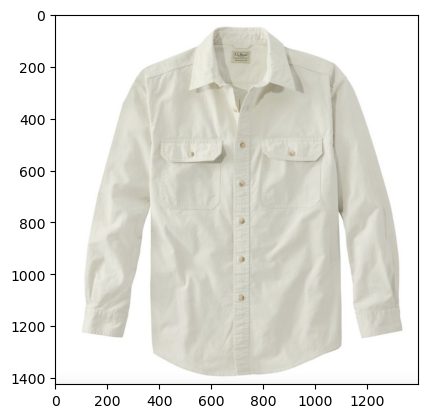

In [10]:
#original image
image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/VisualSearch/Survey_Images/LLBeanShirt.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Make sure to click a point on the pop up image for this function to continue on.


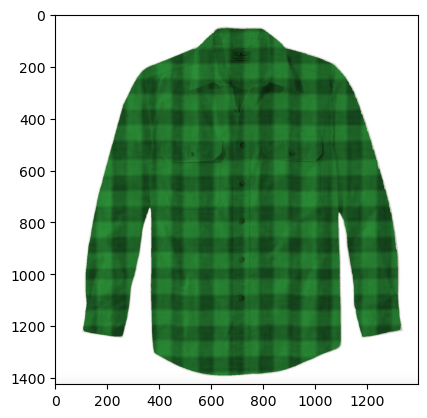

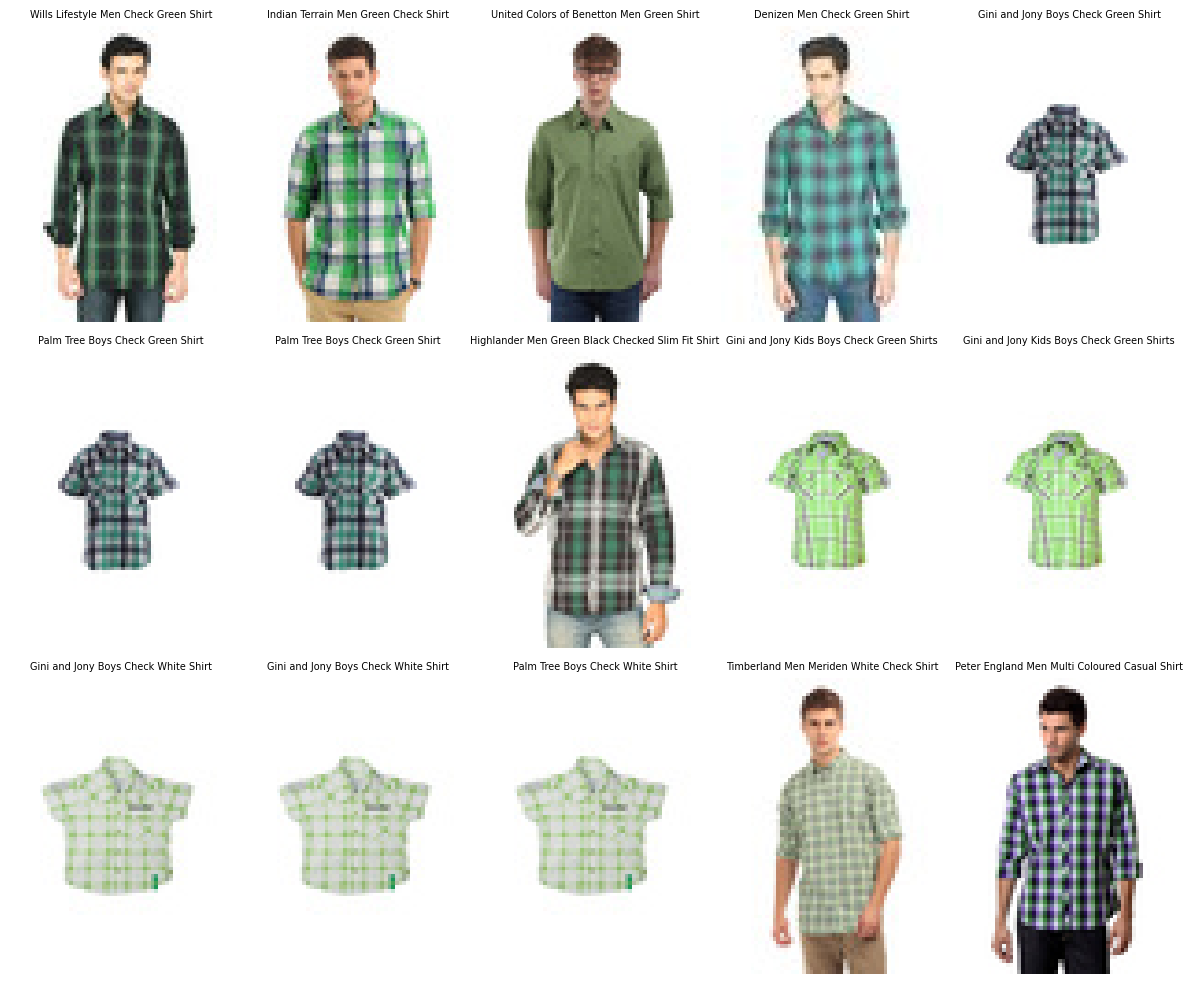

In [11]:
#What image do you want to alter and search with
image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/VisualSearch/Survey_Images/LLBeanShirt.png'

#What color change?
color = "dark green"

#Stores the selection from the drop down as the pattern change
pattern = root.selection

#If you want to include the type of object in the text query
clothing_type = "shirt"

#Combines the above information to be used as the text query in the search
text = color + " " + pattern + " " + clothing_type

#Don't forget to click the point on the pop up for SAM after running this cell!
#This code will take a moment to finish
doColorAndPatternChange(color, pattern, image_path, text)

# Below are separate function from within the Pattern and Color Change code in case they could be used separately

In [12]:
#look here for color and pattern changes
def segment(image_path):
    #While I have the selection of a point here, incorporating the rectangle and point input for SAM could improve this
    print("Make sure to click a point on the pop up image for this function to continue on.")
    clicked_point = get_clicked_point(image_path)

    
    #Store image properly for code below
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image1 = image.copy()
    #sets SAM based on that image
    predictor.set_image(image)
    
    #These inputs might be altered again if the rectangle for SAM is implemented
    input_point = np.array(clicked_point)
    input_label = np.array([1])
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    
    #Store which points of are pixel fall in the selected max
    int_mask = masks.astype(int)
    
    
    width = image.shape[0]
    height = image.shape[1]
    
    #Puts white background on image 
    for i in range(width):
        for j in range(height):
            # getting the current RGB value of pixel (i,j).
            if int_mask[0][i][j]==0:
                  image[i][j]=(255,255,255)
    plt.imshow(image)


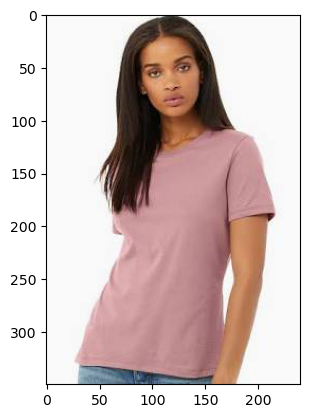

In [13]:
#Original image
image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/modelWithShirt.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Make sure to click a point on the pop up image for this function to continue on.


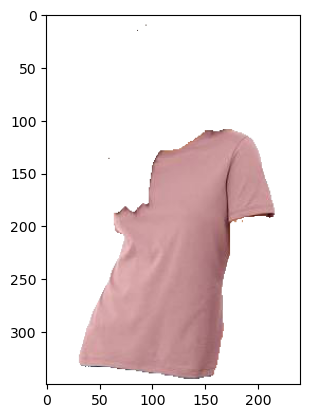

In [14]:
segment('/Users/meagankenney/IMA Bootcamp/Ebay/modelWithShirt.jpeg')


In [15]:
#Pattern Change function alone
def patternChange(pattern, segmented_Image):
    #TWhile I have the selection of a point here, incorporating the rectangle and point input for SAM could improve this
    print("Make sure to click a point on the pop up image for this function to continue on.")
    clicked_point = get_clicked_point(image_path)

    
    #Store image properly for code below
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image1 = image.copy()
    #sets SAM based on that image
    predictor.set_image(image)
    
    #These inputs might be altered again if the rectangle for SAM is implemented
    input_point = np.array(clicked_point)
    input_label = np.array([1])
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    
    #Store which points of are pixel fall in the selected max
    int_mask = masks.astype(int)
    
    
    width = image.shape[0]
    height = image.shape[1]
    
    #Finds the average color of the pixels on the mask
    colList=[]
    for i in range(width):
        for j in range(height):
            # getting the current RGB value of pixel (i,j).
            if int_mask[0][i][j]==1:
                colList.append(image[i][j])
    L=len(colList)
    m1=0
    m2=0
    m3=0
    for i in colList:
        m1+=i[0]
        m2+=i[1]
        m3+=i[2]
    AvgCol = [(m1/L, m2/L, m3/L)]
    

    pattern_name = pattern.replace(" ", "_")
    #will need to modify next location where image is saved
    pattern_path = '/Users/meagankenney/IMA Bootcamp/Ebay/VisualSearch/Fabric_Swatches/' + pattern_name + ".jpeg"
    pattern = Image.open(pattern_path)
    
    #Resize selected fabric swatch to the size of the image being altered
    pattern_resized = pattern.resize((height, width))
    pattern_resized.save(pattern_path)
    pattern = cv2.imread(pattern_path)
    pattern = cv2.cvtColor(pattern, cv2.COLOR_BGR2RGB)
    #Fix a base color
    startCol = AvgCol
    dif = []
    #Store how different is this base color from target color on the pixels we're changing in order to retain details of the clothing item
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                dif1 = startCol[0][0] - pattern[i][j][0]
                dif2 = startCol[0][1] - pattern[i][j][1]
                dif3 = startCol[0][2] - pattern[i][j][2]
                #dif1 = pattern[i][j][0]
                #dif2 =  pattern[i][j][1]
                #dif3 =  pattern[i][j][2]
                dif.append((dif1,dif2,dif3))
    #Make blank list for new color values
    newColR=[]
    newColG=[]
    newColB=[]

    #Make lists of the shifted colors from old to new RGB values
    c= 0
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                newColR.append(image[i][j][0]-dif[c][0])
                newColG.append(image[i][j][1]-dif[c][1])
                newColB.append(image[i][j][2]-dif[c][2])
                c+=1
    #Rescale each color list to make sure it's in appropriate RGB value range
    minR = max(min(newColR), 0)
    maxR = min(max(newColR), 255)
    minG = max(min(newColG), 0)
    maxG = min(max(newColG), 255)
    minB = max(min(newColB), 0)
    maxB = min(max(newColB), 255)
    fixedColR = scale_list(newColR, minR,maxR)
    fixedColG = scale_list(newColG, minG,maxG)
    fixedColB =scale_list(newColB, minB,maxB)
    #Go through all pixels in the picture and set them to their new color
    n=0
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                image[i][j][0]=fixedColR[n]
                image[i][j][1]=fixedColG[n]
                image[i][j][2] = fixedColB[n]
                n+=1
                
    #This does the same on the non-segmented image in case you want to use image1, which retains more than the segmented part from the original image, as your image query            
    n=0
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                image1[i][j][0]=fixedColR[n]
                image1[i][j][1]=fixedColG[n]
                image1[i][j][2] = fixedColB[n]
                n+=1
                
    #if you show the image you'll only show the altered segment, if you show image1 it will be the original photo with the altered segment          
    #plt.imshow(image)            
    plt.imshow(image1)
    
   

Make sure to click a point on the pop up image for this function to continue on.


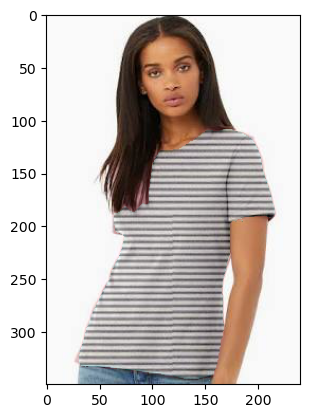

In [16]:
#Note you would have to know the name of the fabric in the database here as is indicated in the dropdown for the 
#doColorAndPatternChange function
patternChange("horizontal thin stripes", '/Users/meagankenney/IMA Bootcamp/Ebay/modelWithShirt.jpeg')


In [17]:
#Translate a color name into an RGB value
def get_rgb_from_color_name(color_name):
    try:
        rgb = webcolors.name_to_rgb(color_name)
        return tuple(rgb)
    except ValueError:
        return None


def colorChange(color, image_path):
    #TWhile I have the selection of a point here, incorporating the rectangle and point input for SAM could improve this
    print("Make sure to click a point on the pop up image for this function to continue on.")
    clicked_point = get_clicked_point(image_path)

    
    #Store image properly for code below
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image1 = image.copy()
    #sets SAM based on that image
    predictor.set_image(image)
    
    #These inputs might be altered again if the rectangle for SAM is implemented
    input_point = np.array(clicked_point)
    input_label = np.array([1])
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    
    #Store which points of are pixel fall in the selected max
    int_mask = masks.astype(int)
    
    
    width = image.shape[0]
    height = image.shape[1]
    
    #Puts white background on image 
    for i in range(width):
        for j in range(height):
            # getting the current RGB value of pixel (i,j).
            if int_mask[0][i][j]==0:
                  image[i][j]=(255,255,255)
    
    #Finds the average color of the pixels on the mask
    colList=[]
    for i in range(width):
        for j in range(height):
            # getting the current RGB value of pixel (i,j).
            if int_mask[0][i][j]==1:
                colList.append(image[i][j])
    L=len(colList)
    m1=0
    m2=0
    m3=0
    for i in colList:
        m1+=i[0]
        m2+=i[1]
        m3+=i[2]
    AvgCol = [(m1/L, m2/L, m3/L)]
        
    #Fix a base color
    startCol = AvgCol
    #Web Colors has a really weird brown 
    if color =="brown":
        color = "saddlebrown"
    color_name = color
    color_name =  color_name.replace(" ", "")
    newColor = get_rgb_from_color_name(color_name)
    
    
    #Note the code above this is replaced by a hex color picker in the Streamlit app which eliinages the need for the code above
    
    #Reduces the intensity of the most pigmented colors like red, blue, and green (Again this is not necessary with the Hex color picker)
    fixColor = []
    fixColor.append(str(newColor[0]))
    fixColor.append(str(newColor[1]))
    fixColor.append(str(newColor[2]))
        
        
    if newColor[0]==255 and newColor[1]==0 and newColor[2]==0:
        fixColor[1] ="65"
        
    if newColor[0]==0 and newColor[1]==255 and newColor[2]==0:
        fixColor[0] = "65"
    if newColor[0]==0 and newColor[1]==0 and newColor[2]==255:
        fixColor[1] = "65"
        
    newColor = (int(fixColor[0]),int(fixColor[1]),int(fixColor[2]))
        
    #Stores how different is this base color from target color (again to retain details of original item)
    dif1 = startCol[0][0] - newColor[0]
    dif2 = startCol[0][1] - newColor[1]
    dif3 = startCol[0][2] - newColor[2]
    #Make blank list for new color values
    newColR=[]
    newColG=[]
    newColB=[]
    #Make lists of the shifted colors from old to new RGB values
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                newColR.append(image[i][j][0]-dif1)
                newColG.append(image[i][j][1]-dif2)
                newColB.append(image[i][j][2]-dif3)
    #Rescale each color list to make sure it's in appropriate RGB value range
    minR = max(min(newColR), 0)
    maxR = min(max(newColR), 255)
    minG = max(min(newColG), 0)
    maxG = min(max(newColG), 255)
    minB = max(min(newColB), 0)
    maxB = min(max(newColB), 255)
    fixedColR = scale_list(newColR, minR,maxR)
    fixedColG = scale_list(newColG, minG,maxG)
    fixedColB =scale_list(newColB, minB,maxB)
    #Go through all pixels in the picture and set them to their new color
    n=0
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                image[i][j][0]=fixedColR[n]
                image[i][j][1]=fixedColG[n]
                image[i][j][2] = fixedColB[n]
                n+=1
                
    #This does the same on the non-segmented image in case you want to use image1, which retains more than the segmented part from the original image, as your image query                
    n=0
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                image1[i][j][0]=fixedColR[n]
                image1[i][j][1]=fixedColG[n]
                image1[i][j][2] = fixedColB[n]
                n+=1
    #if you show the image you'll only show the altered segment, if you show image1 it will be the original photo with the altered segment          
    #plt.imshow(image)            
    plt.imshow(image1)

    

Make sure to click a point on the pop up image for this function to continue on.


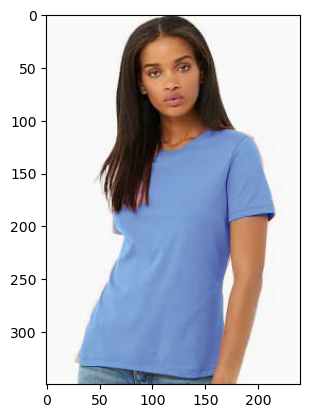

In [18]:
colorChange("cornflower blue", '/Users/meagankenney/IMA Bootcamp/Ebay/modelWithShirt.jpeg')
